In [ ]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
device_list = tf.test.gpu_device_name()


In [ ]:
device_list

'/device:GPU:0'

In [ ]:
from zipfile import ZipFile
with ZipFile('/content/CK+FER1.zip' , 'r') as zips:
  zips.extractall()

In [ ]:
from tensorflow.keras.layers import Layer, Dense, Flatten
from tensorflow.keras import Model

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers datasets


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import os
from PIL import Image

def load_and_preprocess_image(img_path):
    img = Image.open(img_path)

    img = img.resize((48, 48))

    if img.mode != 'RGB':
        img = img.convert('RGB')

    img_array = np.array(img)

    return img_array.tolist()





In [ ]:
def prepare_fer_data_from_directory(data_directory):

    image_list = []
    image_labels = []

    emotion_folders = sorted(os.listdir(data_directory))

    for label_index, emotion_folder in enumerate(emotion_folders):
        emotion_path = os.path.join(data_directory, emotion_folder)

        for image_filename in os.listdir(emotion_path):
            image_path = os.path.join(emotion_path, image_filename)

            image = load_and_preprocess_image(image_path)

            image_list.append(image)
            image_labels.append(label_index)

    output_dataframe = pd.DataFrame(list(zip(image_list, image_labels)),
                                     columns=['image', 'label'])

    return output_dataframe


In [ ]:
input_df = prepare_fer_data_from_directory('/content/CK+FER1/content/CK_FER_images1')

In [ ]:
import pandas as pd
import numpy as np


num_images_per_label = 4000

selected_images = []
selected_labels = []

for label in input_df['label'].unique():
    label_subset = input_df[input_df['label'] == label]
    random_indices = np.random.choice(label_subset.index, num_images_per_label)
    selected_images.extend(label_subset.loc[random_indices, 'img'])
    selected_labels.extend(label_subset.loc[random_indices, 'label'])

selected_data_df = pd.DataFrame({'img': selected_images, 'label': selected_labels})



In [ ]:
selected_data_df = selected_data_df.reset_index(drop=True)

In [ ]:
from sklearn.model_selection import train_test_split

train_data_df, remaining_data_df = train_test_split(selected_data_df, test_size=0.3, random_state=42)
val_data_df, test_data_df = train_test_split(remaining_data_df, test_size=0.5, random_state=42)

print("Train DataFrame shape:", train_data_df.shape)
print("Validation DataFrame shape:", val_data_df.shape)
print("Test DataFrame shape:", test_data_df.shape)


Train DataFrame shape: (19600, 2)
Validation DataFrame shape: (4200, 2)
Test DataFrame shape: (4200, 2)


In [ ]:
train_data_df.head()

,img,label
1208,"[[[220, 220, 220], [222, 222, 222], [223, 223,...",0
439,"[[[186, 186, 186], [192, 192, 192], [201, 201,...",0
8819,"[[[54, 54, 54], [65, 65, 65], [66, 66, 66], [7...",2
15720,"[[[70, 70, 70], [61, 61, 61], [60, 60, 60], [5...",3
5593,"[[[9, 9, 9], [10, 10, 10], [13, 13, 13], [18, ...",1


In [ ]:
train_data_df.reset_index(drop=True, inplace=True)
test_data_df.reset_index(drop=True, inplace=True)
val_data_df.reset_index(drop=True, inplace=True)

# Print the DataFrame to verify the updated index
print(train_data_df)

                                                     img  label
0      [[[220, 220, 220], [222, 222, 222], [223, 223,...      0
1      [[[186, 186, 186], [192, 192, 192], [201, 201,...      0
2      [[[54, 54, 54], [65, 65, 65], [66, 66, 66], [7...      2
3      [[[70, 70, 70], [61, 61, 61], [60, 60, 60], [5...      3
4      [[[9, 9, 9], [10, 10, 10], [13, 13, 13], [18, ...      1
...                                                  ...    ...
19595  [[[214, 214, 214], [196, 196, 196], [201, 201,...      5
19596  [[[21, 21, 21], [21, 21, 21], [22, 22, 22], [2...      1
19597  [[[34, 34, 34], [39, 39, 39], [56, 56, 56], [1...      0
19598  [[[55, 55, 55], [47, 47, 47], [43, 43, 43], [4...      3
19599  [[[250, 250, 250], [255, 255, 255], [184, 184,...      5

[19600 rows x 2 columns]


In [ ]:

print(len(train_data_df))
print(len(test_data_df))
print(len(val_data_df))

19600
4200
4200


In [ ]:
from datasets import Dataset
import numpy as np

train_dataset = Dataset.from_pandas(train_data_df)

splits = train_dataset.train_test_split(test_size=0.15)

train_dataset = splits["train"]

val_dataset = Dataset.from_pandas(val_data_df)
test_dataset = Dataset.from_pandas(test_data_df)

train_dataset


Dataset({
    features: ['img', 'label'],
    num_rows: 16660
})

In [ ]:
np.array(train_dataset[0]['img']).shape



(48, 48, 3)

In [ ]:
val_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 735
})

In [ ]:
def preprocess_images(examples):

    images = examples['img']
    images = [np.array(image, dtype=np.uint8) for image in images]
    images = [np.moveaxis(image, source=-1, destination=0) for image in images]
    # preprocess and add pixel_values
    inputs = feature_extractor(images=images)
    examples['pixel_values'] = inputs['pixel_values']

    return examples

In [ ]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
from datasets import Features, ClassLabel, Array3D

features = Features({
    'label': ClassLabel(names=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']),
    'img': Array3D(dtype="int64", shape=(3, 48, 48)),
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
})

preprocessed_train_dataset = train_dataset.map(preprocess_images, batched=True, batch_size=1, features=features)
import pickle
with open('preprocessed_train_dataframe.pickle', 'wb') as handle:
    pickle.dump(preprocessed_train_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)


Map:   0%|          | 0/16660 [00:00<?, ? examples/s]

In [ ]:
preprocessed_val_ds['img']

In [ ]:
{
  "do_normalize": True,
  "do_rescale": True,
  "do_resize": True,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

NameError: ignored

In [ ]:
import pickle
# Save the preprocessed train dataset
with open('preprocessed_train_dataframe.pickle', 'wb') as handle:
    pickle.dump(preprocessed_train_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
preprocessed_val_dataset = val_dataset.map(preprocess_images, batched=True, batch_size=1, features=features)


Map:   0%|          | 0/4200 [00:00<?, ? examples/s]

In [ ]:
preprocessed_test_dataset = test_dataset.map(preprocess_images, batched=True, batch_size=1, features=features)


Map:   0%|          | 0/4200 [00:00<?, ? examples/s]

In [ ]:
import pickle
with open('preprocessed_val_dataframe.pickle', 'wb') as handle:
    pickle.dump(preprocessed_val_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
import pickle

# Load the preprocessed train dataset
with open('/content/preprocessed_train_dataframe.pickle', 'rb') as handle:
    preprocessed_train_ds = pickle.load(handle)

# Load the preprocessed validation dataset
with open('/content/preprocessed_val_dataframe.pickle', 'rb') as handle:
    preprocessed_val_ds = pickle.load(handle)

In [ ]:

from datasets import *
from transformers import ViTFeatureExtractor
from transformers import ViTModel
from transformers import TrainingArguments, Trainer
from transformers.modeling_outputs import SequenceClassifierOutput
import numpy as np
import pandas as pd
import torch.nn as nn
import pickle
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
string_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']


In [ ]:
vittt = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

In [ ]:
vittt

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [ ]:
pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 3.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense
from transformers import TFAutoModel

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=len(string_labels)):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


vit_model = ViTForImageClassification()





In [ ]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)


<ipython-input-24-e0422430864c>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
training_args = TrainingArguments(
    output_dir='./output_dir',
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    logging_dir='logs',
)

trainer = Trainer(
    model= vit_model,
    args=training_args,
    train_dataset=preprocessed_train_ds,
    eval_dataset=preprocessed_val_ds,
    compute_metrics = compute_metrics
)

trainer.train()

results = trainer.evaluate()

print(results)


Epoch,Training Loss,Validation Loss,Accuracy
1,1.031300,0.900970,0.687381
2,0.734300,0.760119,0.742143
3,0.507700,0.678540,0.775000
4,0.336700,0.673172,0.789524
5,0.221700,0.664786,0.797143


{'eval_loss': 0.6647855043411255, 'eval_accuracy': 0.7971428571428572, 'eval_runtime': 158.7144, 'eval_samples_per_second': 26.463, 'eval_steps_per_second': 1.657, 'epoch': 5.0}


In [ ]:
import json

# Define your configuration settings
preprocessing_config_dict = {
  "do_normalize": True,
  "do_rescale": True,
  "do_resize": True,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}


# Save the configuration to a JSON file
with open("/content/saved_vit_model/preprocessor_config.json", "w") as config_file:
    json.dump(preprocessing_config_dict , config_file, indent=4)

print("config.json file created.")

config.json file created.


In [ ]:
from transformers import ViTConfig

config_dict = {
    "hidden_size": 768,
    "num_hidden_layers": 12,
    "num_attention_heads": 12,
    "intermediate_size": 3072,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "layer_norm_eps": 1e-12,
    "gradient_checkpointing": False,
    "transformers_version": "4.10.0",
    "architectures": ["ViTModel"],
}

# Create a ViTConfig instance from the configuration dictionary
vit_config = ViTConfig(**config_dict)

# Save the configuration to a JSON file
with open("/content/saved_vit_model/config.json", "w") as config_file:
    json.dump(vit_config.to_dict(), config_file, indent=4)

print("config.json file created.")

config.json file created.


In [ ]:
test_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 4200
})

In [ ]:
outputs = trainer.predict(preprocessed_test_ds)
print(outputs.metrics)


{'test_loss': 0.6966096758842468, 'test_accuracy': 0.7914285714285715, 'test_runtime': 160.0141, 'test_samples_per_second': 26.248, 'test_steps_per_second': 1.644}


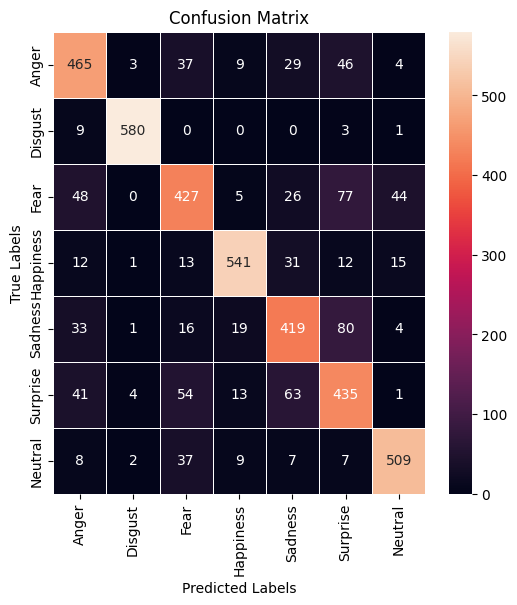

In [ ]:
# Extract true labels and predicted labels from model outputs
true_labels = outputs.label_ids
predicted_labels = outputs.predictions.argmax(1)

# Create a confusion matrix
confusion_matrix_data = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(6, 6))
heatmap = sns.heatmap(confusion_matrix_data, annot=True, fmt="d", linewidths=.5,
                      xticklabels=string_labels, yticklabels=string_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import pandas as pd
import numpy as np


# Get labels from the diagonal of the confusion matrix
labels = [f'Class {i}' for i in range(confusion_matrix_data.shape[0])]

# Create a raw table
raw_table = []
for i, true_class in enumerate(labels):
    row = [true_class]
    for j, predicted_class in enumerate(labels):
        count = confusion_matrix_data[i, j]
        row.append(count)
    raw_table.append(row)

# Convert raw table to Pandas DataFrame
column_names = ['True Class'] + labels
df = pd.DataFrame(raw_table, columns=column_names)

# Print the raw table as DataFrame
print(df)


  True Class  Class 0  Class 1  Class 2  Class 3  Class 4  Class 5  Class 6
0    Class 0      465        3       37        9       29       46        4
1    Class 1        9      580        0        0        0        3        1
2    Class 2       48        0      427        5       26       77       44
3    Class 3       12        1       13      541       31       12       15
4    Class 4       33        1       16       19      419       80        4
5    Class 5       41        4       54       13       63      435        1
6    Class 6        8        2       37        9        7        7      509


In [ ]:
trainer.save_model("/content/saved_vit_model/")

In [ ]:
import shutil

# Path to the folder you want to zip
folder_path = '/content/saved_vit_model'  # Replace with your folder path

# Path to save the zip file
zip_file_path = '/content/saved_vit_model.zip'  # Replace with your desired zip file path

shutil.make_archive(zip_file_path[:-4], 'zip', folder_path)

print(f"Folder '{folder_path}' zipped to '{zip_file_path}'.")


Folder '/content/saved_vit_model' zipped to '/content/saved_vit_model.zip'.


In [ ]:
from google.colab import files

files.download(zip_file_path)


In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

tokenizer = ViTFeatureExtractor.from_pretrained('/content/saved_vit_model/')
model = ViTForImageClassification.from_pretrained('/content/saved_vit_model/', return_dict=False, num_labels=7)


In [ ]:
type(model)


transformers.models.vit.modeling_vit.ViTForImageClassification

In [ ]:
from transformers import Trainer
trainer1 = Trainer(model=model)

# Preprocess the test dataset for prediction

# Make predictions using the Trainer
predictions = trainer1.predict(preprocessed_test_ds)

print(predictions.predictions)


[[ 1.0706822  -1.9472556   3.027032   ... -1.4297595   1.2246646
  -0.68919545]
 [ 3.5868855   0.00830811 -0.85618925 ... -0.764612   -0.37752452
  -1.0388521 ]
 [-0.57001877  4.9612665  -1.0900664  ... -0.7020846  -1.0089831
  -0.67078894]
 ...
 [-0.6284247   4.9681497  -0.8783802  ... -0.78414214 -1.1395155
  -0.6309588 ]
 [-1.6346575  -1.356848    0.50893396 ...  0.07001142 -1.0199925
   3.6154356 ]
 [ 1.865477   -1.7670327   0.81824523 ... -1.3608097  -1.0615743
  -0.5103094 ]]


In [ ]:
print(predictions.metrics)


{'test_loss': 0.696609616279602, 'test_runtime': 154.6145, 'test_samples_per_second': 27.164, 'test_steps_per_second': 3.396}


In [ ]:
outputs1 = model.predict(preprocessed_test_ds)
print(outputs1.metrics)


AttributeError: ignored

In [ ]:

outputs = model.predict(preprocessed_val_ds)
print(outputs.metrics)


AttributeError: ignored